# HW2:  SHAP analysis Boston Housing dataset `506 samples and 13 feature variables`

---

**Citation**：
- [1] https://github.com/dmlc/xgboost.git
- [2] https://github.com/scikit-learn/scikit-learn.git
- [3] https://github.com/shap/shap
- [4] http://lib.stat.cmu.edu/datasets/boston

> ** 透過[1] XGBoost 與 [3] shap 套件分析**特徵重要性**。


In [17]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 設定隨機種子確保可重現性
np.random.seed(42)

# Figure Chinese font settings
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

## 1. 載入 Boston Housing 資料集

In [4]:
data_path = 'data/boston.dataset.txt'
raw_df = pd.read_csv(data_path, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT'  # 移除 'MEDV'
]
df = pd.DataFrame(data, columns=column_names)
df['MEDV'] = target  # 單獨加入 target

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 2. 資料前處理

In [5]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
## 3. 定義評估函數

In [6]:
def evaluate_model(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mape, rmse, r2

## 4. 訓練模型

In [7]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model_full = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model_full.fit(X_train_full, y_train_full)

y_pred_full = model_full.predict(X_test)
mape_full, rmse_full, r2_full = evaluate_model(y_test, y_pred_full)

print(f"測試集績效 → MAPE: {mape_full:.4f}, RMSE: {rmse_full:.4f}, R²: {r2_full:.4f}")

測試集績效 → MAPE: 0.0970, RMSE: 2.3515, R²: 0.9246


## 5. SHAP 特徵重要性分析與重要性排名（依 SHAP 平均絕對值）

特徵重要性排名（依 SHAP 平均絕對值）:
    feature  shap_importance
0     LSTAT         3.320014
1        RM         2.948928
2       DIS         0.668252
3       NOX         0.666280
4   PTRATIO         0.647301
5       AGE         0.579053
6      CRIM         0.547478
7       TAX         0.354852
8         B         0.323959
9     INDUS         0.148690
10      RAD         0.144707
11       ZN         0.081317
12     CHAS         0.054107


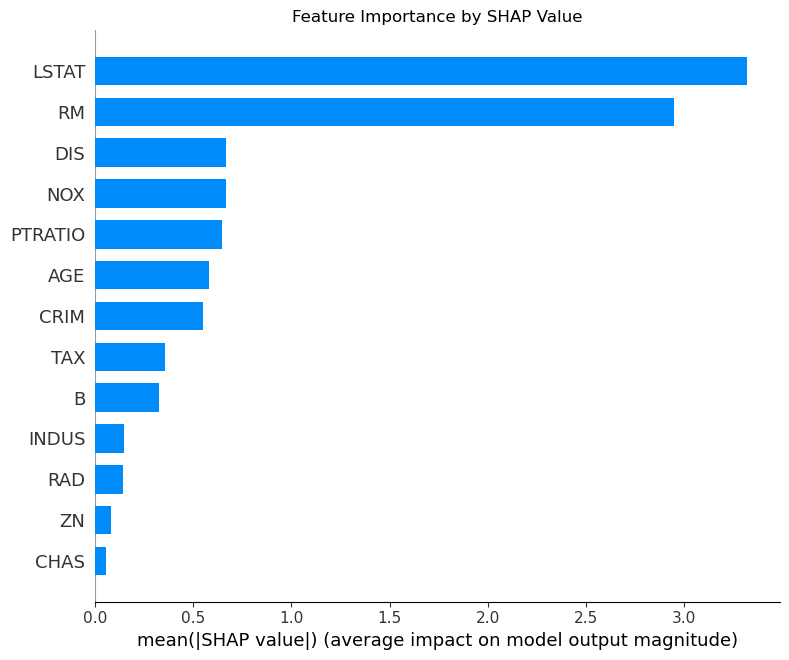

In [10]:
explainer = shap.TreeExplainer(model_full)
shap_values = explainer.shap_values(X_train_full)

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_train_full.columns,
    'shap_importance': shap_sum
}).sort_values('shap_importance', ascending=False)

print("特徵重要性排名（依 SHAP 平均絕對值）:")
print(importance_df.reset_index(drop=True))

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_full, plot_type="bar", show=False)
plt.title("Feature Importance by SHAP Value")
plt.tight_layout()
plt.show()

## 6. 特徵篩選（保留前 5 重要特徵）

In [11]:
top_features = importance_df.head(5)['feature'].tolist()
print(f"選取前 5 重要特徵: {top_features}")

X_train_reduced = X_train_full[top_features]
X_test_reduced = X_test[top_features]

# 重新訓練模型
model_reduced = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model_reduced.fit(X_train_reduced, y_train_full)

y_pred_reduced = model_reduced.predict(X_test_reduced)
mape_red, rmse_red, r2_red = evaluate_model(y_test, y_pred_reduced)

print(f"測試集績效（前5特徵） → MAPE: {mape_red:.4f}, RMSE: {rmse_red:.4f}, R²: {r2_red:.4f}")

選取前 5 重要特徵: ['LSTAT', 'RM', 'DIS', 'NOX', 'PTRATIO']
測試集績效（前5特徵） → MAPE: 0.1150, RMSE: 2.7943, R²: 0.8935


## 7. 特徵績效指標比較表

In [ ]:
results_comparison = pd.DataFrame({
    '模型': ['ALL 特徵', 'TOP 5 特徵'],
    'MAPE': [mape_full, mape_red],
    'RMSE': [rmse_full, rmse_red],
    'R²': [r2_full, r2_red],
})

print("特徵刪減前後績效指標比較:")
print(results_comparison.round(4))

特徵刪減前後績效比較:
         模型   MAPE    RMSE      R²
0    ALL 特徵  0.097  2.3515  0.9246
1  TOP 5 特徵  0.115  2.7943  0.8935


## 8. 實際 vs 預測圖

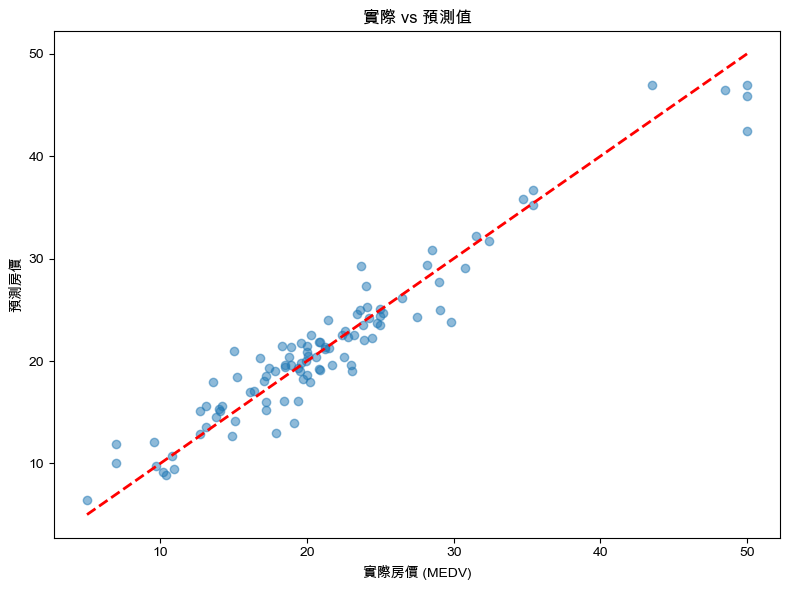

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_full, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('實際房價 (MEDV)')
plt.ylabel('預測房價')
plt.title('實際 vs 預測值')
plt.tight_layout()
plt.show()